In [1]:
from fastai.text import Path, Counter, pickle, torch, to_np, partial, 
    LanguageModelLoader, LanguageModelData
import html
import pandas as pd
from src.text_tools import fixup, get_texts, get_all
%load_ext autoreload
%autoreload 2

In [2]:
LM_PATH=Path('/contents/data/lm/')

In [3]:
chunksize = 24000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [4]:
tok_trn, trn_labels = get_all(df_trn, 0)
tok_val, val_labels = get_all(df_val, 0)

0
1
2
3
4
5
0


In [5]:
(LM_PATH/'tmp').mkdir(exist_ok=True)
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')
freq = Counter(p for o in tok_trn for p in o)
print(freq.most_common(25))

[('the', 939529), (',', 937586), ('and', 843817), ('to', 696765), ('.', 675539), ('of', 658040), ('national', 371673), ('our', 337562), ('a', 289155), ('in', 259328), ('monuments', 250030), ('for', 239780), ('that', 238589), ('these', 238488), ('i', 208366), ('lands', 207722), ('are', 206792), ('public', 178379), ('monument', 174107), ('-', 172432), ('all', 146249), ('have', 140037), ("'s", 134031), ('as', 130597), ('is', 130157)]


In [6]:
max_vocab = 40000
min_freq = 2

In [7]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [8]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

39286

In [9]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [10]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [11]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [12]:
vs=len(itos)
vs,len(trn_lm)

(39286, 124284)

## wikitext103 conversion¶
We are now going to build an english language model for the National Monuments corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(like wikipedia articles) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

We source a LM called the wikitext103 LM created by Stephen Merity @ Salesforce research. 
using the command : wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [13]:
em_sz,nh,nl = 400,1150,3

In [14]:
PATH = Path('/contents')
PRE_PATH = PATH/'models_v2'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [4]:
#%%bash
#wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-11-25 17:25:43--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘{PATH}/models/wt103/index.html’

     0K                                                       100%  157M=0s

2018-11-25 17:25:44 (157 MB/s) - ‘{PATH}/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-11-25 17:25:44--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-11-25 17:25:44 ERROR 404: Not Found.

--2018-11-25 17:25:44--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘{PATH}/models/wt103/index.html?C=N;O=D’

     0K                                      

In [15]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [16]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [17]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the NatMon LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown NatMon tokens that do not exist in wikitext103.

In [18]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [19]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [20]:
wd = 1e-7
bptt = 70
bs = 52 
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)
drop_factor = 0.8
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*drop_factor
lr=1e-3
lrs = lr

In [21]:
learner = md.get_model(opt_fn, em_sz, nh, nl,\
                       dropouti=drops[0], dropout=drops[1], wdrop=drops[2],\
                       dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [22]:
learner.model.load_state_dict(wgts)

In [23]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      2.415503   2.183065   0.60473   



[array([2.18306]), 0.6047301374828543]

 76%|███████▌  | 4550/5980 [46:05<14:31,  1.64it/s, loss=8.55] 

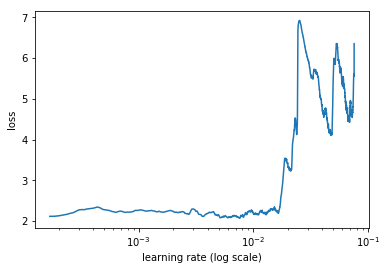

In [ ]:
learner.save('lm_last_ft')
learner.load('lm_last_ft')
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*100, linear=True)
learner.sched.plot()


In [ ]:
lrs = 2e-3
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)
learner.save('lm1')
learner.save_encoder('lm1_enc')
learner.sched.plot_loss()


epoch      trn_loss   val_loss   accuracy                       
    0      1.797521   1.708668   0.673488  
    1      1.764547   1.65243    0.681081                       
    2      1.699048   1.620819   0.685509                       
    3      1.656517   1.596448   0.689016                       
 98%|█████████▊| 5842/5980 [1:00:29<01:30,  1.53it/s, loss=1.6] 